Projeto: Análise de atrito de funcionários RH IBM.
Descrição: Projeto de ciência de dados para prever a saída (attrition) de funcionários, 
utilizando o dataset IBM HR Analytics. O objetivo principal é apoiar a área de 
Recursos Humanos (RH) na implementação de estratégias de retenção proativas.

Autor: Ivan Luís Duarte

LinkedIn: https://www.linkedin.com/in/ivanluisduarte/

GitHub: https://github.com/ivanluisduarte

Data de Criação: 2025-10-23

Licença: MIT

# Busca pelo melhor modelo

## Importações

In [1]:
# facilita a análise de coeficientes
from src.auxiliares import fnc_dataframe_coeficientes

from src.config import (
    DADOS_LIMPOS,  # dados de entrada
    N_JOBS,        # controla o número de núcleos processadores utilizados
    RANDOM_STATE,  # semente para replicar os resultados noutro momento
)
from src.graficos import (
    PALETTE_TEMPERATURA,  # paleta de cores para gráficos e tabelas
    plot_comparar_metricas_modelos,  # facilita a comparação de modelos
    plot_matrizes_confusao,  # facilita a plotagem de matrizes de confusão
)
from src.models import (
    fnc_extended_classification_report,  # facilita a análise de resultados
    fnc_treinar_e_validar_modelo_classificacao,  # facilita treino e validação
)

import numpy as np
import pandas as pd

# codificação WOE - Weight of Evidence - para categorias nominais com muitas opções
from category_encoders.woe import WOEEncoder

# undersampling para balancear os dados de treino e validação
from imblearn.under_sampling import RandomUnderSampler

from sklearn.compose import ColumnTransformer  # para preparar os dados

# importancia de variáveis para classificação
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import (  # para normalizar os dados de entrada
    LabelEncoder,  # para codificação do target
    MinMaxScaler,  # para mudar a escala das colunas numéricas uniformes
    OrdinalEncoder,  # para codificação de categorias ordinais
    OneHotEncoder,  # para codificação de categoricas nominais com poucas opções
    PowerTransformer,  # para mudar a escala das colunas numéricas não uniformes
)

# classificador referência
from sklearn.dummy import DummyClassifier

# estudo linear
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# estudo SVM - Support Vector Machine
from sklearn.svm import SVC

# estudo kNN - k Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

## Funções auxiliares

In [2]:
# não precisava ser uma função, mas fica mais organizado assim.
# também não justifica um arquivo só para isso.
def fnc_get_colunas_ordenadas(
    colunas_ordenadas: list | tuple | np.ndarray | pd.Series
) -> list:
    '''
        Retorna as colunas em ordem de importância, removendo duplicatas

        Args:
            colunas_ordenadas: list | tuple | np.ndarray | pd.Series
        Returns:
            list: Lista de colunas em duplicidade na ordem de importancia

        Examples:
            >>> resultado = fnc_get_colunas_ordenadas(coefs.index)
            >>> print(resultado)
            ['salario', 'carga_horaria']
    '''

    # removendo duplicatas e mantendo ordem da lista
    return list(dict.fromkeys(
        [x.split('__')[1].split('_')[0] for x in colunas_ordenadas]
    ))

In [3]:
# não precisava ser uma função, mas fica mais organizado assim.
# também não justifica um arquivo só para isso.
def fnc_scale_pos_weight(y, flg_print=True, flg_return=False):
    """
    Calcula a proporção entre o número de instâncias da classe 0 e da classe 1.

    Args:
        y (array-like): Array com as classes das instâncias.
        flg_print (bool, optional): Se deve imprimir a proporção. 
            Por padrão é True.
        flg_return (bool, optional): Se deve retornar a proporção.
            Por padrão é False.

    Returns:
        float or None: A proporção entre o número de instâncias da classe 0 e da classe 1
        se flg_return for True. Caso contrário, retorna None.
    """
    if flg_print or flg_return:
        # Conta o número de instâncias para cada classe
        c0, c1 = np.bincount(y)
    else:
        return None

    # Calcula a proporção entre o número de instâncias da classe 0 e da classe 1
    scale_pos_weight = c0 / c1

    # Imprime a proporção
    if flg_print:
        print(f'{c0} / {c1} = {scale_pos_weight}')

    if flg_return:
        return scale_pos_weight

## Carregando dados

In [4]:
df = pd.read_parquet(DADOS_LIMPOS)

with pd.option_context('display.max_columns', None):
    display(df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department-JobRole,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,41,Yes,Travel_Rarely,1102,Sales - Sales Executive,1,College,Life Sciences,Medium,Female,94,High,2,Very High,Single,5993,19479,8,Yes,11,Excellent,Low,0,8,0,Bad,6,4,0,5
2,49,No,Travel_Frequently,279,Research & Development - Research Scientist,8,Below College,Life Sciences,High,Male,61,Medium,2,Medium,Married,5130,24907,1,No,23,Outstanding,Very High,1,10,3,Better,10,7,1,7
4,37,Yes,Travel_Rarely,1373,Research & Development - Laboratory Technician,2,College,Other,Very High,Male,92,Medium,1,High,Single,2090,2396,6,Yes,15,Excellent,Medium,0,7,3,Better,0,0,0,0
5,33,No,Travel_Frequently,1392,Research & Development - Research Scientist,3,Master,Life Sciences,Very High,Female,56,High,1,High,Married,2909,23159,1,Yes,11,Excellent,High,0,8,3,Better,8,7,3,0
7,27,No,Travel_Rarely,591,Research & Development - Laboratory Technician,2,Below College,Medical,Low,Male,40,High,1,Medium,Married,3468,16632,9,No,12,Excellent,Very High,1,6,3,Better,2,2,2,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Age                       1470 non-null   uint8   
 1   Attrition                 1470 non-null   category
 2   BusinessTravel            1470 non-null   category
 3   DailyRate                 1470 non-null   uint16  
 4   Department-JobRole        1470 non-null   category
 5   DistanceFromHome          1470 non-null   uint8   
 6   Education                 1470 non-null   category
 7   EducationField            1470 non-null   category
 8   EnvironmentSatisfaction   1470 non-null   category
 9   Gender                    1470 non-null   category
 10  HourlyRate                1470 non-null   uint8   
 11  JobInvolvement            1470 non-null   category
 12  JobLevel                  1470 non-null   category
 13  JobSatisfaction           1470 non-null   category
 1

## Definindo transformações das colunas

In [6]:
# coluna target - alvo binário: Yes/No
coluna_alvo = 'Attrition'  # transformação label encoder

# categorias ordinais
colunas_categoricas_OrdinalEncoder = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobLevel',
    'JobSatisfaction',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'StockOptionLevel',
    'WorkLifeBalance',
]

# poucas categorias sem ordenação
colunas_categoricas_OneHotEncoder = [
    'BusinessTravel',
    'Gender',
    'MaritalStatus',
    'OverTime',
]

# muitas categorias sem ordenação
colunas_categoricas_WOEEncoder = ['Department-JobRole', 'EducationField']

# distribuição quase uniforme
colunas_numericas_MinMaxScaler = ['DailyRate', 'HourlyRate', 'MonthlyRate']


# distribuição de sino distante da normal.
# skewness e kurtosis ruins e algumas com outliers e calda longa.
colunas_numericas_PowerTransformer = [
    coluna for coluna in df.columns
    if coluna not in (
        [coluna_alvo] +
        colunas_categoricas_WOEEncoder +
        colunas_categoricas_OneHotEncoder +
        colunas_categoricas_OrdinalEncoder +
        colunas_numericas_MinMaxScaler
    )
]


colunas_numericas_PowerTransformer

['Age',
 'DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [7]:
tpl_cat_ordinal = ('ordinal', OrdinalEncoder(
    categories='auto'), colunas_categoricas_OrdinalEncoder)
tpl_cat_one_hot = ('one_hot', OneHotEncoder(drop='first'),
                   colunas_categoricas_OneHotEncoder)
tpl_cat_WOE = ('woe', WOEEncoder(random_state=RANDOM_STATE),
               colunas_categoricas_WOEEncoder)
tpl_num_min_max = ('min_max', MinMaxScaler(), colunas_numericas_MinMaxScaler)
tpl_num_power = ('power', PowerTransformer(),
                 colunas_numericas_PowerTransformer)

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        tpl_cat_one_hot,
        tpl_cat_ordinal,
        tpl_cat_WOE,
    ],
    remainder='passthrough',  # mantém as colunas numéricas sem alterações
    n_jobs=N_JOBS,  # controla o número de núcleos processadores utilizados
)

preprocessamento = ColumnTransformer(
    transformers=[
        tpl_cat_one_hot,
        tpl_cat_ordinal,
        tpl_cat_WOE,
        tpl_num_min_max,
        tpl_num_power
    ],
    remainder='passthrough',  # não sobra mais nada nesse caso
    n_jobs=N_JOBS,  # controla o número de núcleos processadores utilizados
)

## Dividindo X e y

In [8]:
X = df.drop(columns=coluna_alvo)

with pd.option_context('display.max_columns', None):
    display(X.head(3))

,Age,BusinessTravel,DailyRate,Department-JobRole,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1,41,Travel_Rarely,1102,Sales - Sales Executive,1,College,Life Sciences,Medium,Female,94,High,2,Very High,Single,5993,19479,8,Yes,11,Excellent,Low,0,8,0,Bad,6,4,0,5
2,49,Travel_Frequently,279,Research & Development - Research Scientist,8,Below College,Life Sciences,High,Male,61,Medium,2,Medium,Married,5130,24907,1,No,23,Outstanding,Very High,1,10,3,Better,10,7,1,7
4,37,Travel_Rarely,1373,Research & Development - Laboratory Technician,2,College,Other,Very High,Male,92,Medium,1,High,Single,2090,2396,6,Yes,15,Excellent,Medium,0,7,3,Better,0,0,0,0


In [9]:
y = df[coluna_alvo]
y.to_frame().head(3)

,Attrition
1,Yes
2,No
4,Yes


### Transformando y

In [10]:
le = LabelEncoder()

y = le.fit_transform(y)

y[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [11]:
le.inverse_transform(y)[:10]

array(['Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'No'],
      dtype=object)

### Separando treino e validação

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE
)

X_test.shape[0] / X.shape[0]

0.2

In [13]:
# vai ser usado para balancear as classes
scale_pos_weight = fnc_scale_pos_weight(y_train, flg_return=True)

# apenas para visualização
fnc_scale_pos_weight(y_test)
fnc_scale_pos_weight(y)

986 / 190 = 5.189473684210526
247 / 47 = 5.25531914893617
1233 / 237 = 5.2025316455696204


## Preparando os classificadores

In [14]:
# para evitar overfitting em árvores
MAX_DEPTH = 10

# undersampling para balancear as classes
sampler = RandomUnderSampler(random_state=RANDOM_STATE)

# dicionário com os classificadores a serem testados
classificadores = {
    # Classificador de referência
    'Dummy': {
        'preprocessor': None,
        'sampler': None,
        'clf': DummyClassifier(random_state=RANDOM_STATE, strategy='stratified'),
    },

    # Regressão logística com balanceamento das classes
    'LogisticRegression_balanced': {
        'preprocessor': preprocessamento,
        'sampler': None,
        'clf': LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=N_JOBS),
    },

    # Regressão logística com undersampler
    'LogisticRegression_sampler': {
        'preprocessor': preprocessamento,
        'sampler': sampler,
        'clf': LogisticRegression(random_state=RANDOM_STATE, class_weight=None, n_jobs=N_JOBS),
    },

    # Árvore de decisão com balanceamento das classes
    'DecisionTree_balanced': {
        'preprocessor': preprocessamento_arvore,
        'sampler': None,
        'clf': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced', max_depth=MAX_DEPTH),
    },

    # Árvore de decisão com undersampler
    'DecisionTree_sampler': {
        'preprocessor': preprocessamento_arvore,
        'sampler': sampler,
        'clf': DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight=None, max_depth=MAX_DEPTH),
    },

    # RandomForest com balanceamento de classes
    'RandomForest_balanced': {
        'preprocessor': preprocessamento_arvore,
        'sampler': None,
        'clf': RandomForestClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            class_weight='balanced', max_depth=MAX_DEPTH, verbose=0
        ),
    },

    # RandomForest com undersampler
    'RandomForest_sampler': {
        'preprocessor': preprocessamento_arvore,
        'sampler': sampler,
        'clf': RandomForestClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            class_weight=None, max_depth=MAX_DEPTH, verbose=0
        ),
    },
    # LGBM com balanceamento de classes
    'LGBM_balanced': {
        'preprocessor': preprocessamento_arvore,
        'sampler': None,
        'clf': LGBMClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            class_weight='balanced', max_depth=MAX_DEPTH, verbose=-1
        ),
    },

    # LGBM com undersampler
    'LGBM_sampler': {
        'preprocessor': preprocessamento_arvore,
        'sampler': sampler,
        'clf': LGBMClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            class_weight=None, max_depth=MAX_DEPTH, verbose=-1
        ),
    },

    # LGBM com scale
    'LGBM_scale': {
        'preprocessor': preprocessamento_arvore,
        'sampler': None,
        'clf': LGBMClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            scale_pos_weight=scale_pos_weight, max_depth=MAX_DEPTH, verbose=-1
        ),
    },

    # XGB com undersampler
    'XGB_sampler': {
        'preprocessor': preprocessamento_arvore,
        'sampler': sampler,
        'clf': XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            scale_pos_weight=None, max_depth=MAX_DEPTH
        ),
    },

    # XGB com scale
    'XGB_scale': {
        'preprocessor': preprocessamento_arvore,
        'sampler': None,
        'clf': XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            scale_pos_weight=scale_pos_weight, max_depth=MAX_DEPTH
        ),
    },

    # SVM com balanceamento de classes
    'SVC_balanced': {
        'preprocessor': preprocessamento,
        'sampler': None,
        'clf': SVC(random_state=RANDOM_STATE, class_weight='balanced', verbose=False),
    },

    # SVM com undersampler
    'SVC_sampler': {
        'preprocessor': preprocessamento,
        'sampler': sampler,
        'clf': SVC(random_state=RANDOM_STATE, class_weight=None, verbose=False),
    },

    # KNN desbalanceado
    'KNN': {
        'preprocessor': preprocessamento,
        'sampler': None,
        'clf': KNeighborsClassifier(n_jobs=N_JOBS),
    },

    # KNN com undersampler
    'KNN_sampler': {
        'preprocessor': preprocessamento,
        'sampler': sampler,
        'clf': KNeighborsClassifier(n_jobs=N_JOBS),
    },
}

len(classificadores)

16

16 algoritmos da um grande número de testes, mas nossa base é pequena e permite essa "travessura".
Além disso, nossas funções de treinamento de validação facilitam o trabalho.

## Treinando e validando os modelos

In [15]:
df_resultados, pipelines = fnc_treinar_e_validar_modelo_classificacao(
    X_train, y_train, classificadores)

metricas = df_resultados.columns[1:]

df_resultados[metricas] = df_resultados[metricas].astype(float)
df_resultados.style.background_gradient(cmap=PALETTE_TEMPERATURA)

,model,test_balanced_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc,time_seconds,fit_time,score_time
0,Dummy,0.479399,0.156827,0.112676,0.121212,0.105263,0.479399,0.046028,0.010707,0.035321
1,Dummy,0.555458,0.167679,0.238806,0.242424,0.235294,0.555458,0.034432,0.003474,0.030958
2,Dummy,0.531896,0.164650,0.202899,0.212121,0.194444,0.531896,0.038664,0.003258,0.035406
3,Dummy,0.450339,0.177569,0.054795,0.066667,0.046512,0.450339,0.022093,0.003202,0.018891
4,Dummy,0.541340,0.183197,0.225352,0.250000,0.205128,0.541340,0.023175,0.003420,0.019756
5,LogisticRegression_balanced,0.668793,0.398975,0.403509,0.302632,0.605263,0.759038,3.065315,2.949618,0.115697
6,LogisticRegression_balanced,0.767706,0.650284,0.477876,0.341772,0.794118,0.854843,0.152952,0.089918,0.063034
7,LogisticRegression_balanced,0.724107,0.535158,0.454545,0.337838,0.694444,0.773730,0.273951,0.151855,0.122097
8,LogisticRegression_balanced,0.739462,0.572637,0.521739,0.416667,0.697674,0.804627,0.150354,0.089124,0.061230
9,LogisticRegression_balanced,0.685309,0.543214,0.427350,0.320513,0.641026,0.780351,0.220682,0.160078,0.060605


In [16]:
df_resultados.groupby('model').mean().sort_values(
    by=['test_recall', 'test_precision'],
    ascending=False
).style.background_gradient(cmap=PALETTE_TEMPERATURA).format('{:.3f}')

,test_balanced_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc,time_seconds,fit_time,score_time
model,,,,,,,,,
LogisticRegression_sampler,0.715,0.528,0.441,0.315,0.736,0.789,0.157,0.092,0.065
RandomForest_sampler,0.711,0.468,0.444,0.326,0.703,0.769,0.343,0.235,0.109
SVC_sampler,0.714,0.503,0.447,0.329,0.702,0.777,0.145,0.075,0.070
XGB_sampler,0.691,0.457,0.418,0.301,0.693,0.764,0.223,0.133,0.090
LogisticRegression_balanced,0.717,0.540,0.457,0.344,0.687,0.795,0.773,0.688,0.085
LGBM_sampler,0.700,0.494,0.433,0.318,0.684,0.759,0.172,0.094,0.078
SVC_balanced,0.746,0.498,0.512,0.415,0.677,0.799,0.208,0.125,0.083
DecisionTree_sampler,0.616,0.209,0.341,0.236,0.617,0.616,0.093,0.044,0.049
KNN_sampler,0.625,0.282,0.350,0.249,0.591,0.667,0.148,0.082,0.066


Priorizando `SVC_balanced` em detrimento do `XGB_sampler`, `LogisticRegression_balanced` e `LGBM_sampler` por causa do seu valor de precisão, que supera os anteriores sem perder muito no recall.

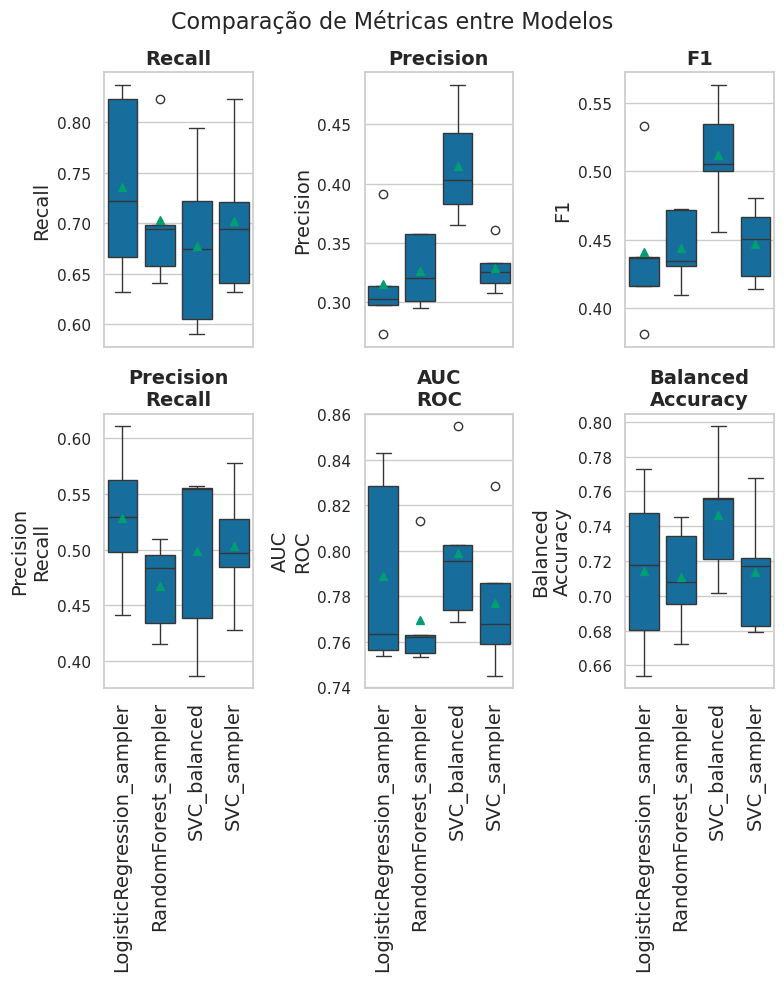

In [17]:
plot_comparar_metricas_modelos(
    df_resultados.loc[
        df_resultados['model'].isin((
            'LogisticRegression_sampler',
            'RandomForest_sampler',
            'SVC_sampler',
            # 'XGB_sampler',
            # 'LogisticRegression_balanced',
            # 'LGBM_sampler',
            'SVC_balanced',
        )),
    ],
    figsize=(8, 10),
    comparar_metricas=(
        'test_recall', 'test_precision', 'test_f1',
        'test_average_precision', 'test_roc_auc', 'test_balanced_accuracy'
    ),
    nomes_metricas=(
        'Recall', 'Precision', 'F1',
        'Precision\nRecall', 'AUC\nROC', 'Balanced\nAccuracy'
    ),

    colunas_graficos=3,
)

Para nosso contexto de perder valiosos funcionários, recall é a métrica mais adequada.
O melhor **recall** é do `LogisticRegression_sampler`, mas com diferenças muito pequenas.

Vamos seguir com 4 modelos ganhadores para ver qual suporta melhor a redução de dimensionalidade desejada para a interface da futura aplicação WEB, sem perder em recall e outras métricas.
Para isso, vamos analisar as *N* melhores variáveis para cada modelo e fazer uma "eleição". Variáveis que participarem de mais modelos serão consideradas boas para seguir.

## Reduzindo a dimensionalidade da base

### RandomForest_sampler

In [18]:
# pipeline com o modelo Random Forest
pipeline = pipelines['RandomForest_sampler']

# treinando o modelo
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [19]:
coefs = fnc_dataframe_coeficientes(
    colunas=pipeline.named_steps['preprocessor'].get_feature_names_out(),
    coeficientes=pipeline.named_steps['clf'].feature_importances_,
)

,coeficiente
remainder__MonthlyIncome,0.069028
one_hot__OverTime_Yes,0.060920
ordinal__StockOptionLevel,0.059069
remainder__YearsAtCompany,0.055764
remainder__DailyRate,0.053879
remainder__TotalWorkingYears,0.053031
remainder__Age,0.052881
woe__Department-JobRole,0.050071
remainder__MonthlyRate,0.048276
remainder__YearsWithCurrManager,0.046975


In [20]:
lst_ordenada_random_forest = fnc_get_colunas_ordenadas(coefs.index)

lst_ordenada_random_forest

['MonthlyIncome',
 'OverTime',
 'StockOptionLevel',
 'YearsAtCompany',
 'DailyRate',
 'TotalWorkingYears',
 'Age',
 'Department-JobRole',
 'MonthlyRate',
 'YearsWithCurrManager',
 'HourlyRate',
 'YearsInCurrentRole',
 'PercentSalaryHike',
 'DistanceFromHome',
 'NumCompaniesWorked',
 'YearsSinceLastPromotion',
 'JobLevel',
 'WorkLifeBalance',
 'EducationField',
 'TrainingTimesLastYear',
 'JobInvolvement',
 'JobSatisfaction',
 'EnvironmentSatisfaction',
 'MaritalStatus',
 'RelationshipSatisfaction',
 'Education',
 'Gender',
 'BusinessTravel',
 'PerformanceRating']

### LogisticRegression_sampler

In [21]:
# pipeline com o modelo Logistic Regression
pipeline = pipelines['LogisticRegression_sampler']

# treinando o modelo
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
coefs = fnc_dataframe_coeficientes(
    colunas=pipeline.named_steps['preprocessor'].get_feature_names_out(),
    coeficientes=pipeline.named_steps['clf'].coef_[0],
)

,coeficiente
one_hot__OverTime_Yes,1.457617
woe__Department-JobRole,0.941438
one_hot__BusinessTravel_Travel_Frequently,0.837131
woe__EducationField,0.785849
one_hot__BusinessTravel_Travel_Rarely,0.738375
min_max__DailyRate,-0.680119
one_hot__MaritalStatus_Single,0.648735
power__YearsInCurrentRole,-0.547661
power__YearsSinceLastPromotion,0.511740
power__YearsWithCurrManager,-0.384328


In [23]:
lst_ordenada_regressao_sampler = fnc_get_colunas_ordenadas(coefs.index)

lst_ordenada_regressao_sampler

['OverTime',
 'Department-JobRole',
 'BusinessTravel',
 'EducationField',
 'DailyRate',
 'MaritalStatus',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Gender',
 'WorkLifeBalance',
 'StockOptionLevel',
 'NumCompaniesWorked',
 'DistanceFromHome',
 'HourlyRate',
 'YearsAtCompany',
 'TrainingTimesLastYear',
 'TotalWorkingYears',
 'PercentSalaryHike',
 'EnvironmentSatisfaction',
 'JobLevel',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'JobSatisfaction',
 'MonthlyRate',
 'Age',
 'MonthlyIncome',
 'Education',
 'JobInvolvement']

### SVC_sampler

In [24]:
# pipeline com o modelo SVC_sampler
pipeline = pipelines['SVC_sampler']

# treinando o modelo
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### permutation_importance
- Valores Positivos: Significam que o embaralhamento piorou a pontuação do modelo, indicando que a feature era importante para a previsão.
- Valores Próximos de Zero: Indicam que a feature tem pouca ou nenhuma importância.
- Valores Negativos: Indicam que o embaralhamento dos dados dessa feature melhorou ligeiramente a pontuação do modelo, ou seja, a versão original da feature estava contribuindo negativamente ou de forma irrelevante.

In [25]:
perm_imp = permutation_importance(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring='recall',
    n_repeats=10,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

In [26]:
coefs = fnc_dataframe_coeficientes(
    colunas=X_train.columns,
    coeficientes=perm_imp.importances_mean,
    flg_ordenacao_por_modulo=False,  # mantém negativos em posições ruins
)

,coeficiente
YearsSinceLastPromotion,0.036842
OverTime,0.033684
Education,0.025263
WorkLifeBalance,0.023684
JobInvolvement,0.017368
BusinessTravel,0.014211
EnvironmentSatisfaction,0.014211
JobSatisfaction,0.014211
DistanceFromHome,0.013684
NumCompaniesWorked,0.012632


In [27]:
lst_ordenada_svc_sampler = coefs.index.to_list()

lst_ordenada_svc_sampler

['YearsSinceLastPromotion',
 'OverTime',
 'Education',
 'WorkLifeBalance',
 'JobInvolvement',
 'BusinessTravel',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'DistanceFromHome',
 'NumCompaniesWorked',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'TotalWorkingYears',
 'YearsWithCurrManager',
 'Age',
 'Department-JobRole',
 'JobLevel',
 'Gender',
 'DailyRate',
 'MaritalStatus',
 'RelationshipSatisfaction',
 'PerformanceRating',
 'HourlyRate',
 'PercentSalaryHike',
 'MonthlyRate',
 'MonthlyIncome',
 'EducationField']

### SVC_balanced

In [28]:
# pipeline com o modelo SVC_balanced
pipeline = pipelines['SVC_balanced']

# treinando o modelo
pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [29]:
perm_imp = permutation_importance(
    estimator=pipeline,
    X=X_train,
    y=y_train,
    scoring='recall',
    n_repeats=10,
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
)

In [30]:
coefs = fnc_dataframe_coeficientes(
    colunas=X_train.columns,
    coeficientes=perm_imp.importances_mean,
    flg_ordenacao_por_modulo=False,  # mantém negativos em posições ruins
)

,coeficiente
JobSatisfaction,0.062105
YearsSinceLastPromotion,0.061579
EnvironmentSatisfaction,0.046316
Education,0.045263
Department-JobRole,0.038947
TotalWorkingYears,0.037895
NumCompaniesWorked,0.034737
YearsWithCurrManager,0.034211
OverTime,0.033158
MaritalStatus,0.032632


In [31]:
lst_ordenada_svc_balanced = coefs.index.to_list()

lst_ordenada_svc_balanced

['JobSatisfaction',
 'YearsSinceLastPromotion',
 'EnvironmentSatisfaction',
 'Education',
 'Department-JobRole',
 'TotalWorkingYears',
 'NumCompaniesWorked',
 'YearsWithCurrManager',
 'OverTime',
 'MaritalStatus',
 'StockOptionLevel',
 'YearsAtCompany',
 'JobInvolvement',
 'JobLevel',
 'MonthlyIncome',
 'YearsInCurrentRole',
 'RelationshipSatisfaction',
 'BusinessTravel',
 'PercentSalaryHike',
 'TrainingTimesLastYear',
 'Age',
 'Gender',
 'DistanceFromHome',
 'WorkLifeBalance',
 'HourlyRate',
 'PerformanceRating',
 'MonthlyRate',
 'DailyRate',
 'EducationField']

### Selecionando as N melhores de cada algoritmo

In [32]:
N = 13  # outros valores foram testados até chegar neste

lst_ordenada_final = \
    lst_ordenada_svc_sampler[:N] + lst_ordenada_svc_balanced[:N] + \
    lst_ordenada_regressao_sampler[:N] + lst_ordenada_random_forest[:N]


lst_ordenada_final

['YearsSinceLastPromotion',
 'OverTime',
 'Education',
 'WorkLifeBalance',
 'JobInvolvement',
 'BusinessTravel',
 'EnvironmentSatisfaction',
 'JobSatisfaction',
 'DistanceFromHome',
 'NumCompaniesWorked',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'StockOptionLevel',
 'JobSatisfaction',
 'YearsSinceLastPromotion',
 'EnvironmentSatisfaction',
 'Education',
 'Department-JobRole',
 'TotalWorkingYears',
 'NumCompaniesWorked',
 'YearsWithCurrManager',
 'OverTime',
 'MaritalStatus',
 'StockOptionLevel',
 'YearsAtCompany',
 'JobInvolvement',
 'OverTime',
 'Department-JobRole',
 'BusinessTravel',
 'EducationField',
 'DailyRate',
 'MaritalStatus',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Gender',
 'WorkLifeBalance',
 'StockOptionLevel',
 'NumCompaniesWorked',
 'MonthlyIncome',
 'OverTime',
 'StockOptionLevel',
 'YearsAtCompany',
 'DailyRate',
 'TotalWorkingYears',
 'Age',
 'Department-JobRole',
 'MonthlyRate',
 'YearsWithCurrManager',
 'HourlyRate',
 'YearsI

In [33]:
# dicionário com valores iguais a zero
dct_contagem = dict.fromkeys(X_train.columns, 0)

# contando as ocorrências
for coluna in lst_ordenada_final:
    dct_contagem[coluna] += 1

dct_contagem

{'Age': 1,
 'BusinessTravel': 2,
 'DailyRate': 2,
 'Department-JobRole': 3,
 'DistanceFromHome': 1,
 'Education': 2,
 'EducationField': 1,
 'EnvironmentSatisfaction': 2,
 'Gender': 1,
 'HourlyRate': 1,
 'JobInvolvement': 2,
 'JobLevel': 0,
 'JobSatisfaction': 2,
 'MaritalStatus': 2,
 'MonthlyIncome': 1,
 'MonthlyRate': 1,
 'NumCompaniesWorked': 3,
 'OverTime': 4,
 'PercentSalaryHike': 1,
 'PerformanceRating': 0,
 'RelationshipSatisfaction': 0,
 'StockOptionLevel': 4,
 'TotalWorkingYears': 2,
 'TrainingTimesLastYear': 0,
 'WorkLifeBalance': 2,
 'YearsAtCompany': 3,
 'YearsInCurrentRole': 3,
 'YearsSinceLastPromotion': 3,
 'YearsWithCurrManager': 3}

In [34]:
# pegando somente que aparecem 2 ou mais vezes
lst_ordenada_final = sorted([x for x, y in dct_contagem.items() if y >= 2])
lst_ordenada_final

['BusinessTravel',
 'DailyRate',
 'Department-JobRole',
 'Education',
 'EnvironmentSatisfaction',
 'JobInvolvement',
 'JobSatisfaction',
 'MaritalStatus',
 'NumCompaniesWorked',
 'OverTime',
 'StockOptionLevel',
 'TotalWorkingYears',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [35]:
# quantidade de colunas finais
len(lst_ordenada_final)

17

In [36]:
print('colunas eliminadas:')
[coluna for coluna in X_train.columns if coluna not in lst_ordenada_final]

colunas eliminadas:


['Age',
 'DistanceFromHome',
 'EducationField',
 'Gender',
 'HourlyRate',
 'JobLevel',
 'MonthlyIncome',
 'MonthlyRate',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'TrainingTimesLastYear']

### Atualizando X com menor dimensionalidade

In [37]:
X_train = X_train[lst_ordenada_final]
X_test = X_test[lst_ordenada_final]

X_train.head(3)

,BusinessTravel,DailyRate,Department-JobRole,Education,EnvironmentSatisfaction,JobInvolvement,JobSatisfaction,MaritalStatus,NumCompaniesWorked,OverTime,StockOptionLevel,TotalWorkingYears,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
441,Travel_Rarely,1275,Research & Development - Research Scientist,College,Very High,High,Very High,Married,1,No,2,11,Better,10,8,1,9
1100,Travel_Rarely,1204,Sales - Sales Executive,Bachelor,Very High,High,Low,Single,0,Yes,0,9,Better,8,7,4,7
592,Non-Travel,635,Sales - Sales Executive,Master,Medium,High,Very High,Single,1,No,0,10,Good,10,3,9,7


In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, 441 to 932
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   BusinessTravel           1176 non-null   category
 1   DailyRate                1176 non-null   uint16  
 2   Department-JobRole       1176 non-null   category
 3   Education                1176 non-null   category
 4   EnvironmentSatisfaction  1176 non-null   category
 5   JobInvolvement           1176 non-null   category
 6   JobSatisfaction          1176 non-null   category
 7   MaritalStatus            1176 non-null   category
 8   NumCompaniesWorked       1176 non-null   uint8   
 9   OverTime                 1176 non-null   category
 10  StockOptionLevel         1176 non-null   category
 11  TotalWorkingYears        1176 non-null   uint8   
 12  WorkLifeBalance          1176 non-null   category
 13  YearsAtCompany           1176 non-null   uint8   
 14  YearsInCurre

## Retreinando os modelos com menos colunas

In [39]:
colunas_categoricas_OrdinalEncoder = [
    coluna for coluna in colunas_categoricas_OrdinalEncoder
    if coluna in lst_ordenada_final
]
colunas_categoricas_OneHotEncoder = [
    coluna for coluna in colunas_categoricas_OneHotEncoder
    if coluna in lst_ordenada_final
]
colunas_categoricas_WOEEncoder = [
    coluna for coluna in colunas_categoricas_WOEEncoder
    if coluna in lst_ordenada_final
]
colunas_numericas_MinMaxScaler = [
    coluna for coluna in colunas_numericas_MinMaxScaler
    if coluna in lst_ordenada_final
]
colunas_numericas_PowerTransformer = [
    coluna for coluna in colunas_numericas_PowerTransformer
    if coluna in lst_ordenada_final
]

tpl_cat_ordinal = ('ordinal', OrdinalEncoder(
    categories='auto'), colunas_categoricas_OrdinalEncoder)
tpl_cat_one_hot = ('one_hot', OneHotEncoder(drop='first'),
                   colunas_categoricas_OneHotEncoder)
tpl_cat_WOE = ('woe', WOEEncoder(random_state=RANDOM_STATE),
               colunas_categoricas_WOEEncoder)
tpl_num_min_max = ('min_max', MinMaxScaler(), colunas_numericas_MinMaxScaler)
tpl_num_power = ('power', PowerTransformer(),
                 colunas_numericas_PowerTransformer)

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        tpl_cat_one_hot,
        tpl_cat_ordinal,
        tpl_cat_WOE,
    ],
    remainder='passthrough',
    n_jobs=N_JOBS,
)

preprocessamento = ColumnTransformer(
    transformers=[
        tpl_cat_one_hot,
        tpl_cat_ordinal,
        tpl_cat_WOE,
        tpl_num_min_max,
        tpl_num_power
    ],
    remainder='passthrough',
    n_jobs=N_JOBS,
)

In [40]:
# dicionário com os classificadores a serem testados
classificadores = {
    # Regressão logística com undersampler
    'LogisticRegression_sampler': {
        'preprocessor': preprocessamento,
        'sampler': sampler,
        'clf': LogisticRegression(random_state=RANDOM_STATE, class_weight=None, n_jobs=N_JOBS),
    },

    # RandomForest com undersampler
    'RandomForest_sampler': {
        'preprocessor': preprocessamento_arvore,
        'sampler': sampler,
        'clf': RandomForestClassifier(
            random_state=RANDOM_STATE, n_jobs=N_JOBS,
            class_weight=None, max_depth=MAX_DEPTH, verbose=0
        ),
    },

    # SVM com balanceamento de classes
    'SVC_balanced': {
        'preprocessor': preprocessamento,
        'sampler': None,
        'clf': SVC(random_state=RANDOM_STATE, class_weight='balanced', verbose=False),
    },

    # SVM com undersampler
    'SVC_sampler': {
        'preprocessor': preprocessamento,
        'sampler': sampler,
        'clf': SVC(random_state=RANDOM_STATE, class_weight=None, verbose=False),
    },
}

In [41]:
df_resultados, pipelines = fnc_treinar_e_validar_modelo_classificacao(
    X_train, y_train, classificadores)

metricas = df_resultados.columns[1:]

df_resultados[metricas] = df_resultados[metricas].astype(float)
df_resultados.style.background_gradient(cmap=PALETTE_TEMPERATURA)

,model,test_balanced_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc,time_seconds,fit_time,score_time
0,LogisticRegression_sampler,0.674907,0.517783,0.403226,0.290698,0.657895,0.787879,0.475132,0.293023,0.182109
1,LogisticRegression_sampler,0.779704,0.589146,0.475410,0.329545,0.852941,0.851478,0.200264,0.132711,0.067553
2,LogisticRegression_sampler,0.725433,0.554823,0.448276,0.325000,0.722222,0.749302,0.114202,0.063103,0.051099
3,LogisticRegression_sampler,0.722444,0.491808,0.488189,0.369048,0.720930,0.797602,0.113813,0.062540,0.051273
4,LogisticRegression_sampler,0.744375,0.514545,0.476923,0.340659,0.794872,0.773417,0.125640,0.060833,0.064807
5,RandomForest_sampler,0.688995,0.476025,0.433962,0.338235,0.605263,0.786683,0.330462,0.214621,0.115841
6,RandomForest_sampler,0.700980,0.486772,0.396825,0.271739,0.735294,0.794191,0.386230,0.269851,0.116379
7,RandomForest_sampler,0.721594,0.483659,0.450450,0.333333,0.694444,0.737228,0.377166,0.266483,0.110683
8,RandomForest_sampler,0.736676,0.571284,0.503937,0.380952,0.744186,0.779009,0.357718,0.259559,0.098159
9,RandomForest_sampler,0.682823,0.456088,0.419355,0.305882,0.666667,0.762690,0.307825,0.221342,0.086483


In [42]:
df_resultados.groupby('model').mean().sort_values(
    by=['test_recall', 'test_precision'],
    ascending=False
).style.background_gradient(cmap=PALETTE_TEMPERATURA).format('{:.3f}')

,test_balanced_accuracy,test_average_precision,test_f1,test_precision,test_recall,test_roc_auc,time_seconds,fit_time,score_time
model,,,,,,,,,
LogisticRegression_sampler,0.729,0.534,0.458,0.331,0.750,0.792,0.206,0.122,0.083
SVC_balanced,0.749,0.528,0.506,0.395,0.704,0.807,0.209,0.113,0.095
SVC_sampler,0.723,0.527,0.463,0.347,0.698,0.789,0.131,0.058,0.073
RandomForest_sampler,0.706,0.495,0.441,0.326,0.689,0.772,0.352,0.246,0.106


Após a redução de dimensionalidade, `LogisticRegression_sampler` manteve-se melhor no recall. Mas o `SVC_balanced` se mostra promissor na precisão. Vamos levar ambos como finalistas e fazer uma avaliação por target.

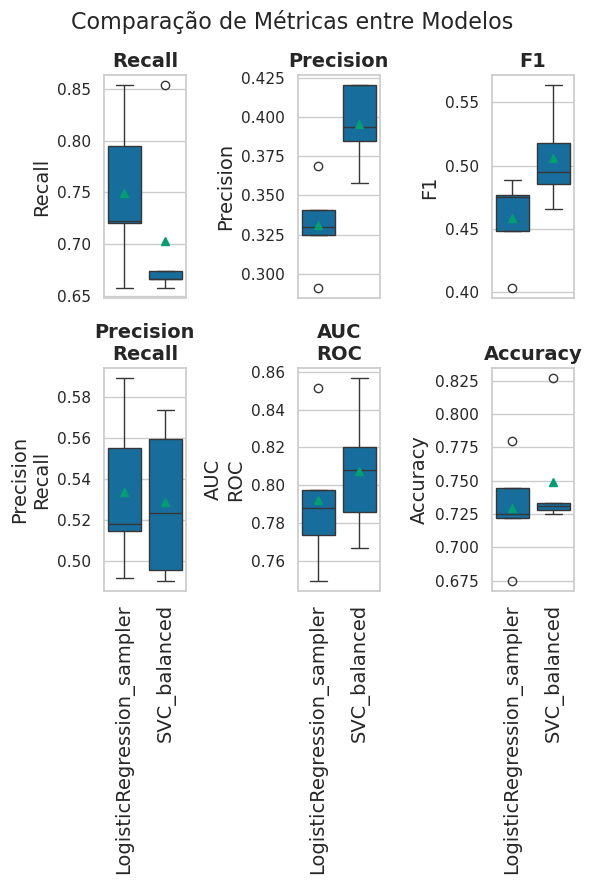

In [43]:
plot_comparar_metricas_modelos(
    df_resultados.loc[
        df_resultados['model'].isin((
            'LogisticRegression_sampler',
            'SVC_balanced',
            # 'SVC_sampler',
            # 'RandomForest_sampler',
        )),
    ],
    figsize=(6, 9),
    comparar_metricas=(
        'test_recall', 'test_precision', 'test_f1',
        'test_average_precision', 'test_roc_auc', 'test_balanced_accuracy'
    ),
    nomes_metricas=(
        'Recall', 'Precision', 'F1',
        'Precision\nRecall', 'AUC\nROC', 'Accuracy'
    ),

    colunas_graficos=3,
    flg_boxplots_horizontais=False,
)

## Avaliando o melhor algoritmo entre os finalistas

Vamos avaliar o melhor recall para o target 1 (yes) no grupo de testes e se forem próximos, podemos ver a melhor precisão.

### LogisticRegression_sampler

In [44]:
pipelines['LogisticRegression_sampler'].fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('sampler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
y_pred = pipelines['LogisticRegression_sampler'].predict(X_test)

fnc_extended_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    y_pred_proba=pipelines['LogisticRegression_sampler'].predict_proba(
        X_test),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.938,0.676,0.786,0.798,0.939,0.690,247
1,Yes,0.310,0.766,0.442,0.798,0.537,0.690,47
2,micro avg,0.690,0.690,0.690,0.782,0.780,0.690,294
3,macro avg,0.624,0.721,0.614,0.798,0.738,0.690,294
4,weighted avg,0.838,0.690,0.731,0.798,0.875,0.690,294


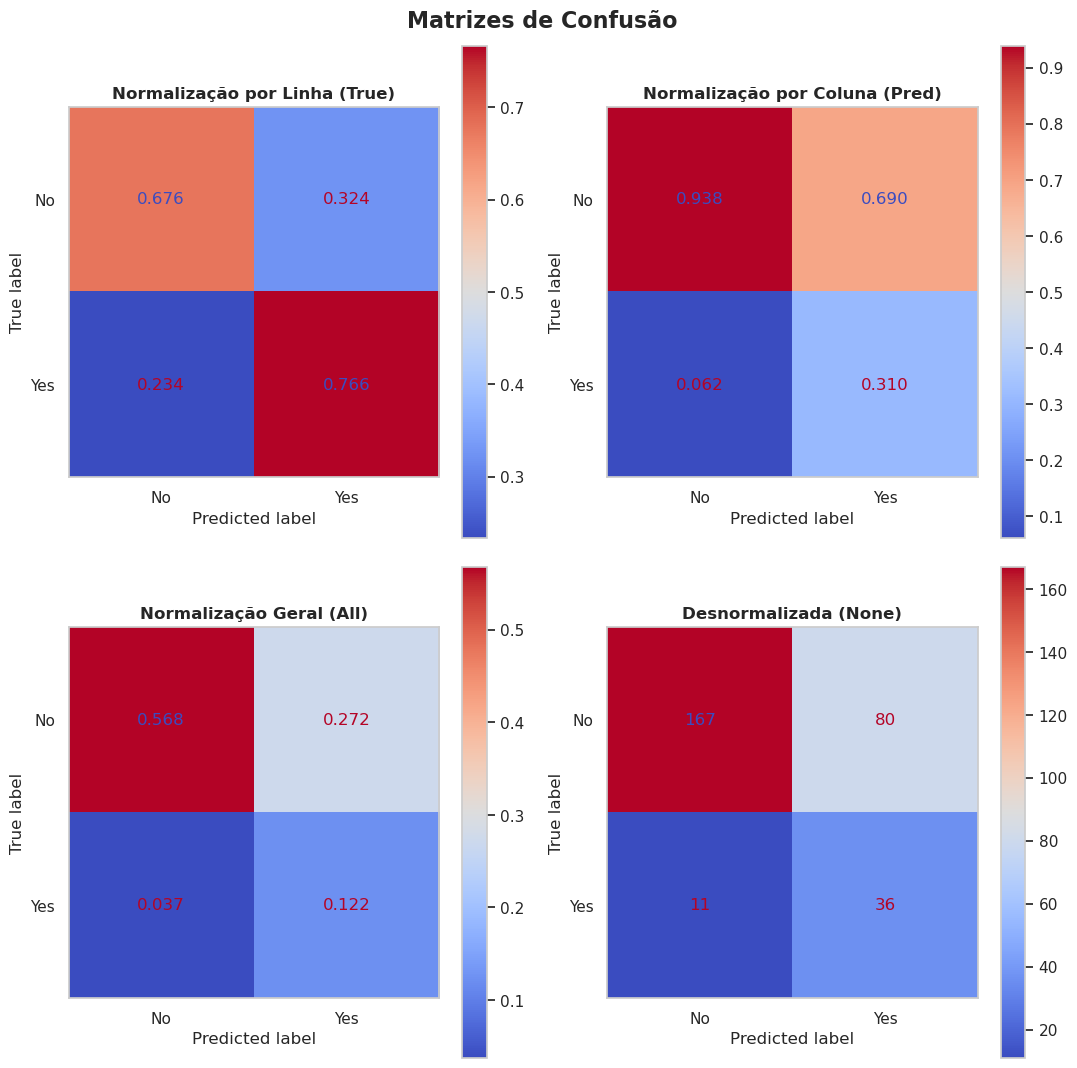

In [46]:
plot_matrizes_confusao(
    modelo=pipelines['LogisticRegression_sampler'],
    X=X_test,
    y=y_test,
    display_labels=le.classes_,
)

### SVC_balanced

In [47]:
pipelines['SVC_balanced'].fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('one_hot', ...), ('ordinal', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,-2
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
y_pred = pipelines['SVC_balanced'].predict(X_test)

fnc_extended_classification_report(
    y_true=y_test,
    y_pred=y_pred,
    y_pred_proba=np.array(list(zip(
        np.zeros(y_test.shape[0]),
        pipelines['SVC_balanced'].decision_function(X_test),
    ))),
    target_names=le.classes_,
)

,Classe,Precisão,Recall,F1-Score,ROC AUC,Precision-Recall,Acurácia,Suporte
0,No,0.925,0.802,0.859,0.500,0.840,0.779,247
1,Yes,0.387,0.660,0.488,0.811,0.552,0.779,47
2,micro avg,0.779,0.779,0.779,0.759,0.733,0.779,294
3,macro avg,0.656,0.731,0.674,0.656,0.696,0.779,294
4,weighted avg,0.839,0.779,0.800,0.550,0.794,0.779,294


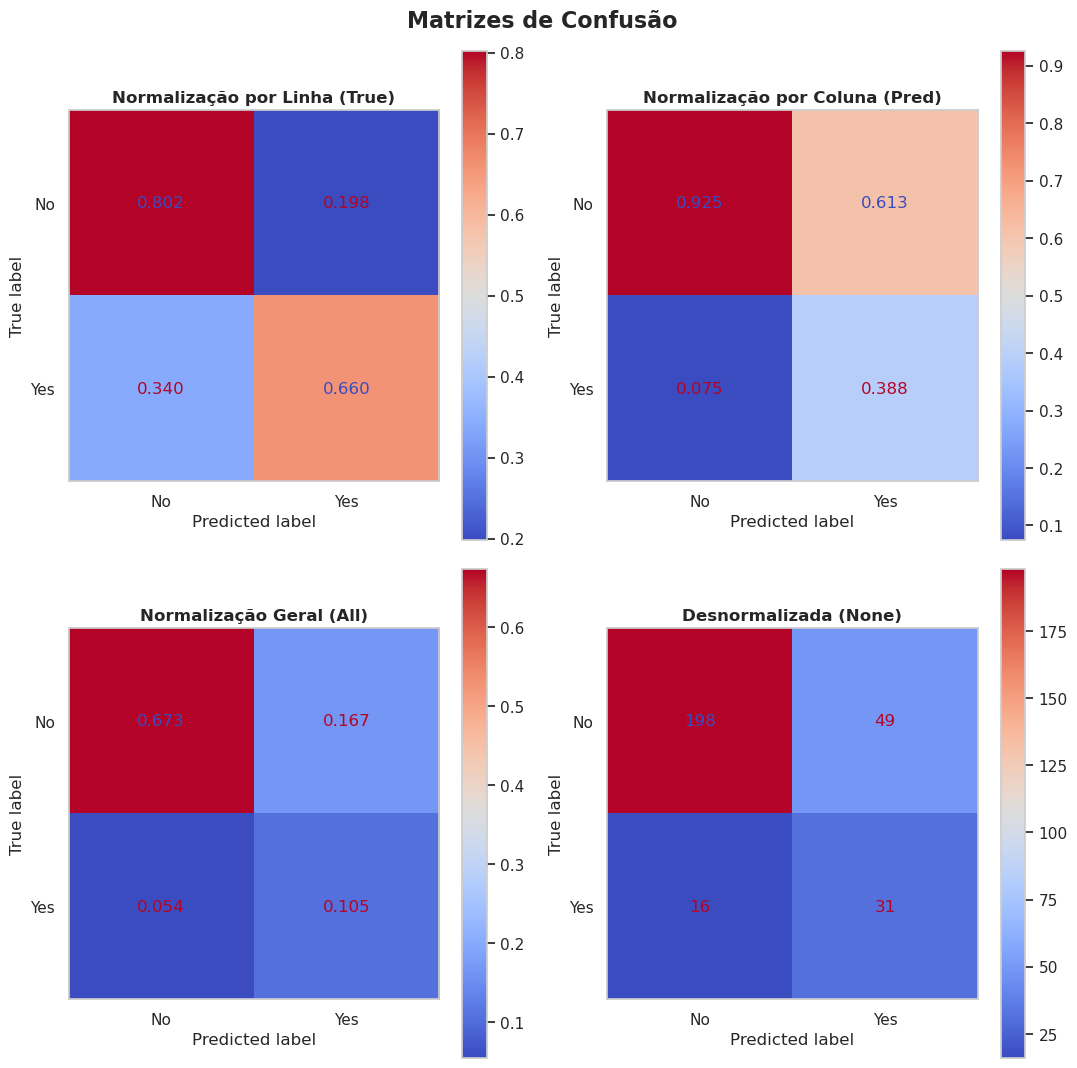

In [49]:
plot_matrizes_confusao(
    modelo=pipelines['SVC_balanced'],
    X=X_test,
    y=y_test,
    display_labels=le.classes_,
)

`LogisticRegression_sampler` continua sendo o grande ganhador.
Vamos agora, na etapa 2 (02-ild-model_etp2.ipynb), buscar o melhor conjunto de hiperparametros para maximizar seu desempenho.